# Scratch RNN - Sprint Notebook

**Goal**  
- Implement a simple Recurrent Neural Network (RNN) from scratch (NumPy only).
- Verify forward propagation on a tiny hand-checkable example.
- (Advanced) Implement full BPTT and train on a small synthetic sequence classification task.
- Plot learning curves and evaluate.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True)
rng = np.random.default_rng(42)  # reproducible

In [2]:
def softmax(logits):
    # logits: (N, C)
    z = logits - np.max(logits, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(y_onehot, p):
    # y_onehot, p: (N, C)
    eps = 1e-12
    return -np.mean(np.sum(y_onehot * np.log(p + eps), axis=1))

def accuracy_from_logits(y_true_int, logits):
    # y_true_int: (N,), logits (N, C)
    pred = np.argmax(logits, axis=1)
    return float(np.mean(pred == y_true_int))

def one_hot(y_int, n_classes):
    y = np.zeros((len(y_int), n_classes), dtype=np.float32)
    y[np.arange(len(y_int)), y_int] = 1.0
    return y

class GetMiniBatch:
    """Simple mini-batch iterator (shuffles once at init)."""
    def __init__(self, X, y, batch_size=32, seed=0):
        self.batch_size = int(batch_size)
        rng_local = np.random.default_rng(seed)
        idx = rng_local.permutation(len(X))
        self._X = X[idx]
        self._y = y[idx]
        self._n = len(X)
        self._stop = int(np.ceil(self._n / self.batch_size))
        self._i = 0

    def __len__(self):
        return self._stop

    def __iter__(self):
        self._i = 0
        return self

    def __next__(self):
        if self._i >= self._stop:
            raise StopIteration
        s = self._i * self.batch_size
        e = min(s + self.batch_size, self._n)
        self._i += 1
        return self._X[s:e], self._y[s:e]

In [3]:
class SimpleRNN:
    """A minimal tanh RNN layer (many-to-one by default).
    Shapes:
      X: (N, T, D)  -> D = n_features
      W_x: (D, H), W_h: (H, H), b: (H,)
      h_t: (N, H)
    """
    def __init__(self, n_features, n_hidden, lr=0.1, init='xavier', clip=5.0):
        self.D = int(n_features)
        self.H = int(n_hidden)
        self.lr = float(lr)
        self.clip = float(clip)
        # Params
        if init == 'xavier':
            limit_wx = np.sqrt(6/(self.D+self.H))
            limit_wh = np.sqrt(6/(self.H+self.H))
            self.W_x = rng.uniform(-limit_wx, limit_wx, size=(self.D, self.H)).astype(np.float32)
            self.W_h = rng.uniform(-limit_wh, limit_wh, size=(self.H, self.H)).astype(np.float32)
            self.b   = np.zeros((self.H,), dtype=np.float32)
        elif init == 'he':
            self.W_x = rng.normal(0, np.sqrt(2/self.D), size=(self.D, self.H)).astype(np.float32)
            self.W_h = rng.normal(0, np.sqrt(2/self.H), size=(self.H, self.H)).astype(np.float32)
            self.b   = np.zeros((self.H,), dtype=np.float32)
        else:
            self.W_x = rng.normal(0, 0.01, size=(self.D, self.H)).astype(np.float32)
            self.W_h = rng.normal(0, 0.01, size=(self.H, self.H)).astype(np.float32)
            self.b   = np.zeros((self.H,), dtype=np.float32)

        # Cache for BPTT
        self.last_X = None
        self.last_hs = None   # list of h_t
        self.last_as = None   # list of a_t
        self.h0 = None

        # Grad buffers
        self.dW_x = np.zeros_like(self.W_x)
        self.dW_h = np.zeros_like(self.W_h)
        self.db   = np.zeros_like(self.b)

    def forward(self, X, h0=None):
        """Forward through time.
        X: (N, T, D)
        Returns h_T (N, H) and stores all intermediates for BPTT.
        """
        N, T, D = X.shape
        assert D == self.D

        if h0 is None:
            h_prev = np.zeros((N, self.H), dtype=np.float32)
        else:
            h_prev = h0.astype(np.float32)

        hs = []
        as_ = []
        for t in range(T):
            x_t = X[:, t, :]                      # (N, D)
            a_t = x_t @ self.W_x + h_prev @ self.W_h + self.b  # (N, H)
            h_t = np.tanh(a_t)                    # (N, H)
            hs.append(h_t)
            as_.append(a_t)
            h_prev = h_t

        self.last_X = X
        self.last_hs = hs
        self.last_as = as_
        self.h0 = h0
        return hs[-1]

    def backward(self, dL_dh_last):
        """Full BPTT for many-to-one: gradient wrt final hidden only is provided.
        dL_dh_last: (N, H)
        Returns dL_dX with shape (N, T, D).
        """
        X = self.last_X
        hs = self.last_hs
        as_ = self.last_as
        N, T, D = X.shape

        # Clear grads
        self.dW_x.fill(0.0)
        self.dW_h.fill(0.0)
        self.db.fill(0.0)

        dX = np.zeros_like(X, dtype=np.float32)

        # Backprop through time
        dh_next = dL_dh_last.copy()  # (N, H)
        for t in reversed(range(T)):
            h_t = hs[t]
            a_t = as_[t]
            h_prev = hs[t-1] if t > 0 else np.zeros_like(h_t)

            # dh/da for tanh = (1 - tanh^2(a))
            da_t = dh_next * (1.0 - np.tanh(a_t)**2)  # (N, H)

            # Accumulate parameter grads
            self.dW_x += X[:, t, :].T @ da_t              # (D, H)
            self.dW_h += h_prev.T @ da_t                  # (H, H)
            self.db   += np.sum(da_t, axis=0)             # (H,)

            # Propagate to previous time and to inputs
            dX[:, t, :] = da_t @ self.W_x.T               # (N, D)
            dh_next = da_t @ self.W_h.T                   # (N, H)

        # Clip (simple global clip for stability)
        for g in (self.dW_x, self.dW_h, self.db):
            np.clip(g, -self.clip, self.clip, out=g)

        return dX

    def step(self):
        # SGD update
        self.W_x -= self.lr * self.dW_x
        self.W_h -= self.lr * self.dW_h
        self.b   -= self.lr * self.db

In [4]:
class Linear:
    def __init__(self, in_dim, out_dim, init='xavier'):
        if init == 'xavier':
            limit = np.sqrt(6/(in_dim+out_dim))
            self.W = rng.uniform(-limit, limit, size=(in_dim, out_dim)).astype(np.float32)
        elif init == 'he':
            self.W = rng.normal(0, np.sqrt(2/in_dim), size=(in_dim, out_dim)).astype(np.float32)
        else:
            self.W = rng.normal(0, 0.01, size=(in_dim, out_dim)).astype(np.float32)
        self.b = np.zeros((out_dim,), dtype=np.float32)
        # caches
        self.last_x = None
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        # x: (N, in_dim)
        self.last_x = x
        return x @ self.W + self.b

    def backward(self, dL_dz):
        # dL_dz: (N, out_dim)
        x = self.last_x
        self.dW = x.T @ dL_dz
        self.db = np.sum(dL_dz, axis=0)
        return dL_dz @ self.W.T

    def step(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

class SoftmaxCELoss:
    def forward(self, logits, y_onehot):
        # returns p, loss
        p = softmax(logits)
        loss = cross_entropy(y_onehot, p)
        return p, loss

    def backward(self, p, y_onehot):
        # dL/dz for softmax+CE = (p - y)/N
        N = p.shape[0]
        return (p - y_onehot) / N

In [5]:
class ScratchSimpleRNNClassifier:
    def __init__(self, n_features, n_hidden, n_classes, lr=0.1, init='xavier', clip=5.0):
        self.rnn = SimpleRNN(n_features, n_hidden, lr=lr, init=init, clip=clip)
        self.head = Linear(n_hidden, n_classes, init=init)
        self.ce = SoftmaxCELoss()
        self.lr = lr
        self.hist = {"train_loss":[], "val_loss":[], "val_acc":[]}

    def predict_logits(self, X):
        # X: (N, T, D)
        hT = self.rnn.forward(X)            # (N, H)
        z  = self.head.forward(hT)          # (N, C)
        return z

    def predict(self, X):
        z = self.predict_logits(X)
        return np.argmax(z, axis=1)

    def fit(self, X, y_int, X_val=None, y_val_int=None, epochs=20, batch_size=64, verbose=True, seed=0):
        N, T, D = X.shape
        n_classes = int(np.max(y_int)+1)
        Y = one_hot(y_int, n_classes)

        for ep in range(epochs):
            mb = GetMiniBatch(X, Y, batch_size=batch_size, seed=seed+ep)
            total = 0.0
            for xb, yb in mb:
                # forward
                hT = self.rnn.forward(xb)
                z  = self.head.forward(hT)
                p, loss = self.ce.forward(z, yb)
                total += loss * len(xb)
                # backward
                dz = self.ce.backward(p, yb)
                dhT = self.head.backward(dz)
                _   = self.rnn.backward(dhT)
                # update
                self.head.step(self.lr)
                self.rnn.step()

            tr_loss = total / len(X)
            self.hist["train_loss"].append(tr_loss)

            if X_val is not None and y_val_int is not None:
                z_val = self.predict_logits(X_val)
                p_val = softmax(z_val)
                v_loss = cross_entropy(one_hot(y_val_int, n_classes), p_val)
                v_acc = accuracy_from_logits(y_val_int, z_val)
                self.hist["val_loss"].append(v_loss)
                self.hist["val_acc"].append(v_acc)
                if verbose:
                    print(f"Epoch {ep+1:02d} | train_loss={tr_loss:.4f}  val_loss={v_loss:.4f}  val_acc={v_acc:.3f}")
            elif verbose:
                print(f"Epoch {ep+1:02d} | train_loss={tr_loss:.4f}")

        return self


## Forward check on tiny example

Verify forward propagation using the small numbers from the assignment (should match the provided `h` vector).


In [6]:
# Tiny example from the prompt
x = np.array([[[1, 2], [2, 3], [3, 4]]], dtype=np.float32)/100.0   # (1, 3, 2)
w_x = np.array([[1, 3, 5, 7], [3, 5, 7, 8]], dtype=np.float32)/100.0  # (2, 4)
w_h = np.array([[1, 3, 5, 7],
                [2, 4, 6, 8],
                [3, 5, 7, 8],
                [4, 6, 8, 10]], dtype=np.float32)/100.0                # (4, 4)
b   = np.array([1, 1, 1, 1], dtype=np.float32)                        # (4,)

# Manual forward loop to match equations:
N, T, D = x.shape
H = w_x.shape[1]
h_prev = np.zeros((N, H), dtype=np.float32)
for t in range(T):
    a_t = x[:, t, :] @ w_x + h_prev @ w_h + b
    h_t = np.tanh(a_t)
    h_prev = h_t

print("Final h:", h_prev)
print("Expected ≈ [0.79494228, 0.81839002, 0.83939649, 0.85584174]")

Final h: [[0.794942 0.81839  0.839396 0.855842]]
Expected ≈ [0.79494228, 0.81839002, 0.83939649, 0.85584174]



## Synthetic sequence classification (many-to-one)

We create a simple parity task:
- Alphabet: integers in `[0, V-1]` encoded as one-hot.
- Sequence length `T`.
- Label: parity of the sum of symbols (`sum % 2`).

Then we train the scratch RNN to predict the parity.


In [7]:
def make_parity_dataset(N=4000, T=12, V=5, seed=7):
    rng_local = np.random.default_rng(seed)
    X_idx = rng_local.integers(0, V, size=(N, T))           # (N, T)
    y_int = np.sum(X_idx, axis=1) % 2                       # (N,)
    # one-hot encode each timestep
    X = np.zeros((N, T, V), dtype=np.float32)
    for i in range(N):
        X[i, np.arange(T), X_idx[i]] = 1.0
    return X, y_int.astype(int)

# Create data
X, y = make_parity_dataset(N=4000, T=12, V=8, seed=123)
# Split train/val/test
N = len(y)
idx = np.arange(N); rng.shuffle(idx)
tr = idx[:int(0.7*N)]; va = idx[int(0.7*N):int(0.85*N)]; te = idx[int(0.85*N):]

X_tr, y_tr = X[tr], y[tr]
X_va, y_va = X[va], y[va]
X_te, y_te = X[te], y[te]

print("Shapes:", X_tr.shape, X_va.shape, X_te.shape)
print("Class balance (train):", {c:int(np.sum(y_tr==c)) for c in np.unique(y_tr)})

Shapes: (2800, 12, 8) (600, 12, 8) (600, 12, 8)
Class balance (train): {np.int64(0): 1410, np.int64(1): 1390}


In [9]:
# Train the scratch RNN
n_features = X_tr.shape[2]
model = ScratchSimpleRNNClassifier(n_features=n_features, n_hidden=32, n_classes=2, lr=0.1, init='xavier', clip=5.0)
model.fit(X_tr, y_tr, X_val=X_va, y_val_int=y_va, epochs=20, batch_size=64, verbose=True, seed=0)

# Evaluate
logits_te = model.predict_logits(X_te)
acc_te = accuracy_from_logits(y_te, logits_te)
print("\nTest Accuracy:", f"{acc_te:.3f}")

Epoch 01 | train_loss=0.7216  val_loss=0.7038  val_acc=0.510
Epoch 02 | train_loss=0.6997  val_loss=0.6957  val_acc=0.517
Epoch 03 | train_loss=0.6947  val_loss=0.6983  val_acc=0.513
Epoch 04 | train_loss=0.6927  val_loss=0.6949  val_acc=0.515
Epoch 05 | train_loss=0.6895  val_loss=0.7009  val_acc=0.528
Epoch 06 | train_loss=0.6885  val_loss=0.6953  val_acc=0.500
Epoch 07 | train_loss=0.6871  val_loss=0.6975  val_acc=0.517
Epoch 08 | train_loss=0.6853  val_loss=0.6965  val_acc=0.513
Epoch 09 | train_loss=0.6856  val_loss=0.6960  val_acc=0.523
Epoch 10 | train_loss=0.6851  val_loss=0.6964  val_acc=0.523
Epoch 11 | train_loss=0.6839  val_loss=0.7028  val_acc=0.515
Epoch 12 | train_loss=0.6817  val_loss=0.7064  val_acc=0.518
Epoch 13 | train_loss=0.6816  val_loss=0.6996  val_acc=0.500
Epoch 14 | train_loss=0.6797  val_loss=0.7039  val_acc=0.500
Epoch 15 | train_loss=0.6793  val_loss=0.7055  val_acc=0.498
Epoch 16 | train_loss=0.6775  val_loss=0.6975  val_acc=0.522
Epoch 17 | train_loss=0.

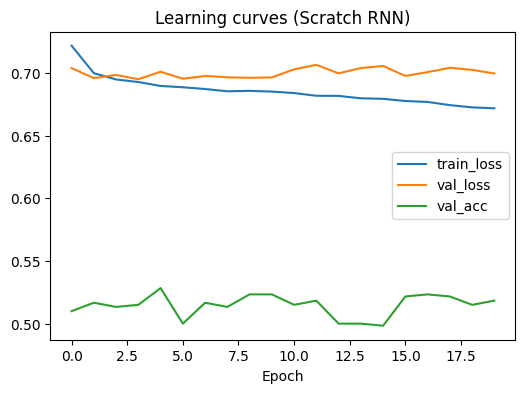

In [10]:
# Plot learning curves
plt.figure(figsize=(6,4))
plt.plot(model.hist["train_loss"], label="train_loss")
if model.hist["val_loss"]:
    plt.plot(model.hist["val_loss"], label="val_loss")
if model.hist["val_acc"]:
    plt.plot(model.hist["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.title("Learning curves (Scratch RNN)"); plt.legend(); plt.show()